In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

In [2]:
nombre_csv = 1
de = pd.read_csv(f'Datos_entrenamiento2/{nombre_csv}_e.csv')
dp = pd.read_csv(f'Datos_prueba2/{nombre_csv}_p.csv')

In [3]:
dp

,Fecha,Hora,period eating,period other,period resting,period rumination,period eating_count,period other_count,period resting_count,period rumination_count,nivel_actividad,distancia,nivel_estres
0,2024-07-02,0,1.000,0.000,0.000,0.000,1.0,0.0,0.0,0.0,0.261201,0.138593,normal
1,2024-07-02,1,0.692,0.000,0.039,0.269,1.0,0.0,1.0,1.0,0.097238,0.238522,peligro
2,2024-07-02,2,0.000,0.000,0.403,0.597,0.0,0.0,1.0,1.0,-0.268779,0.295043,peligro
3,2024-07-02,3,0.000,0.000,0.266,0.734,0.0,0.0,1.0,1.0,-0.269952,0.230329,peligro
4,2024-07-02,4,0.118,0.000,0.436,0.446,1.0,0.0,2.0,1.0,-0.205552,0.132157,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,2024-11-22,19,0.987,0.000,0.000,0.013,1.0,0.0,0.0,1.0,0.254266,0.103209,normal
2756,2024-11-22,20,0.000,0.000,0.000,1.000,0.0,0.0,0.0,1.0,-0.272229,0.221493,alerta
2757,2024-11-22,21,0.243,0.000,0.000,0.757,1.0,0.0,0.0,1.0,-0.142606,0.194993,alerta
2758,2024-11-22,22,0.646,0.354,0.000,0.000,2.0,1.0,0.0,0.0,0.358760,0.173105,alerta


In [4]:
# Contamos las ocurrencias de cada nivel de estrés en la nueva columna
conteo_nivel_estresde = de['nivel_estres'].value_counts()
conteo_nivel_estresdp = dp['nivel_estres'].value_counts()
print(conteo_nivel_estresde)
print(conteo_nivel_estresdp)

nivel_estres
normal     3342
alerta      391
peligro     179
Name: count, dtype: int64
nivel_estres
normal     2357
alerta      287
peligro     116
Name: count, dtype: int64


In [5]:
# Crear un diccionario para mapear cada categoría única en la columna 'nivel_estres' a un número
mapping = {'normal': 0, 'alerta': 1, 'peligro': 2}

# Mapear las categorías a números utilizando el método map de pandas
de['nivel_estres'] = de['nivel_estres'].map(mapping)
dp['nivel_estres'] = dp['nivel_estres'].map(mapping)

# Aplicación de CNN

In [6]:
# Separar características y etiquetas del conjunto de entrenamiento
X_train = de[['period eating','period other','period resting','period rumination']]
y_train = de['nivel_estres']
# Separar características y etiquetas del conjunto de prueba
X_test = dp[['period eating','period other','period resting','period rumination']]
y_test = dp['nivel_estres']


In [7]:
# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Expandir a 24 horas de datos para capturar ciclo diario
timesteps = 36
X_train_reshaped = np.array([X_train_scaled[i:i + timesteps] for i in range(len(X_train_scaled) - timesteps)])
y_train = y_train[timesteps:]
X_test_reshaped = np.array([X_test_scaled[i:i + timesteps] for i in range(len(X_test_scaled) - timesteps)])
y_test = y_test[timesteps:]


In [9]:
# Ajuste de pesos: Calcular pesos de clase para manejar el desbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [10]:
# Convertir etiquetas a formato categórico
y_train_categorical = to_categorical(y_train, num_classes=3)
y_test_categorical = to_categorical(y_test, num_classes=3)

In [11]:
# Definir la arquitectura del modelo CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(36, 3, activation='relu', input_shape=(timesteps, X_train_scaled.shape[1])),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(96, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 neuronas para los 3 niveles de estrés
])

# Compilar el modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'AUC'])

# Entrenar el modelo
history = model.fit(X_train_reshaped, y_train_categorical, epochs=20, batch_size=24,
                    validation_data=(X_test_reshaped, y_test_categorical), class_weight=class_weights_dict)



Epoch 1/20


C:\Users\PC\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - AUC: 0.5355 - accuracy: 0.3353 - loss: 1.1882 - val_AUC: 0.7455 - val_accuracy: 0.5341 - val_loss: 0.9849
Epoch 2/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.6803 - accuracy: 0.4863 - loss: 1.0375 - val_AUC: 0.7306 - val_accuracy: 0.5330 - val_loss: 0.9519
Epoch 3/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.7594 - accuracy: 0.5837 - loss: 0.9369 - val_AUC: 0.4958 - val_accuracy: 0.3175 - val_loss: 1.1978
Epoch 4/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.7532 - accuracy: 0.5700 - loss: 0.8251 - val_AUC: 0.6357 - val_accuracy: 0.4824 - val_loss: 1.0771
Epoch 5/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - AUC: 0.8225 - accuracy: 0.6441 - loss: 0.7602 - val_AUC: 0.6986 - val_accuracy: 0.5466 - val_loss: 1.0041
Epoch 6/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - AUC: 0.8478 - accuracy: 0.6878 - loss: 0.6686 - val_AUC: 0.8247 - val_accuracy: 0.6406 - val_loss: 0.7883
Epoch 7/20
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [12]:
# Predecir las clases del conjunto de prueba
y_pred = model.predict(X_test_reshaped)
y_pred = np.argmax(y_pred, axis=1)

# Contamos las ocurrencias de cada nivel de estrés en y_test y y_pred
valores_unicos, conteos = np.unique(y_test, return_counts=True)
valores_unicos1, conteos1 = np.unique(y_pred, return_counts=True)
ocurrencias = dict(zip(valores_unicos, conteos))
ocurrenciaspre = dict(zip(valores_unicos1, conteos1))

# Mostramos el resultado
print(ocurrencias)
print(ocurrenciaspre)

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
{0: 2331, 1: 281, 2: 112}
{0: 2551, 1: 144, 2: 29}


# Evaluación

In [13]:
from sklearn.preprocessing import label_binarize

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

y_pred= label_binarize(y_pred, classes=[0, 1, 2])

# Calcular el AUC
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Mostrar métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.8098384728340675
Precision: 0.7492788036603021
Recall: 0.8098384728340675
F1 Score: 0.7760283406031735
ROC AUC: 0.5061243620243073


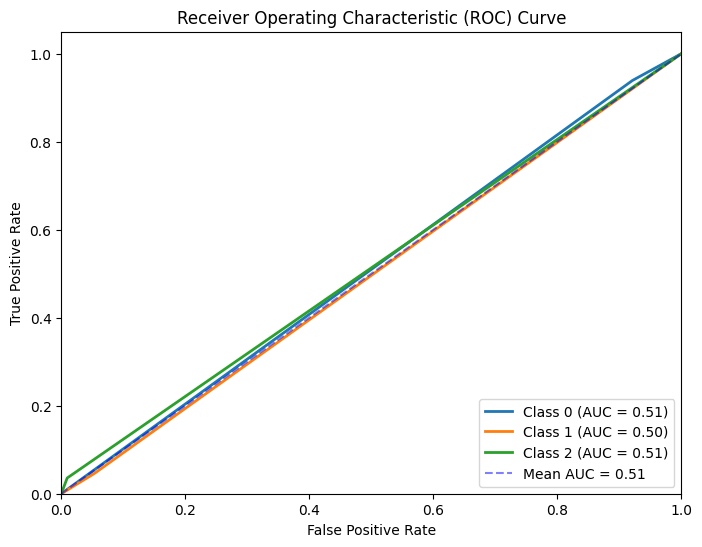

AUC per class: {0: 0.5089811731033105, 1: 0.4963203750129282, 2: 0.5130715379566835}


In [14]:
# Calcular la curva ROC y el AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Extraer los valores
values = roc_auc.values()
# Calcular la media
mean_auc = sum(values) / len(values)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'b--', label=f"Mean AUC = {mean_auc:.2f}", alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
#plt.savefig(f'../Curva_Roc/{nombre_csv}_roc_cnn.png', format='png', dpi=300)
plt.show()
print("AUC per class:", roc_auc)
